# Autism

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import pickle

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import KFold, cross_val_score
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', None)

In [3]:
data = pd.read_csv('input/train.csv')
data.head()

,ID,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,A10_Score,age,gender,ethnicity,jaundice,austim,contry_of_res,used_app_before,result,age_desc,relation,Class/ASD
0,1,1,0,1,0,1,0,1,0,1,1,38.172746,f,?,no,no,Austria,no,6.351166,18 and more,Self,0
1,2,0,0,0,0,0,0,0,0,0,0,47.750517,m,?,no,no,India,no,2.255185,18 and more,Self,0
2,3,1,1,1,1,1,1,1,1,1,1,7.380373,m,White-European,no,yes,United States,no,14.851484,18 and more,Self,1
3,4,0,0,0,0,0,0,0,0,0,0,23.561927,f,?,no,no,United States,no,2.276617,18 and more,Self,0
4,5,0,0,0,0,0,0,0,0,0,0,43.205790,m,?,no,no,South Africa,no,-4.777286,18 and more,Self,0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 22 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               800 non-null    int64  
 1   A1_Score         800 non-null    int64  
 2   A2_Score         800 non-null    int64  
 3   A3_Score         800 non-null    int64  
 4   A4_Score         800 non-null    int64  
 5   A5_Score         800 non-null    int64  
 6   A6_Score         800 non-null    int64  
 7   A7_Score         800 non-null    int64  
 8   A8_Score         800 non-null    int64  
 9   A9_Score         800 non-null    int64  
 10  A10_Score        800 non-null    int64  
 11  age              800 non-null    float64
 12  gender           800 non-null    object 
 13  ethnicity        800 non-null    object 
 14  jaundice         800 non-null    object 
 15  austim           800 non-null    object 
 16  contry_of_res    800 non-null    object 
 17  used_app_before 

In [5]:
df = data.copy()
df.drop(columns=['ID', 'age_desc'], axis=1, inplace=True)

In [6]:
df.shape

(800, 20)

In [7]:
df.ethnicity.value_counts()

White-European     257
?                  203
Middle Eastern      97
Asian               67
Black               47
South Asian         34
Pasifika            32
Others              29
Latino              17
Hispanic             9
Turkish              5
others               3
Name: ethnicity, dtype: int64

In [8]:
df['ethnicity'].replace('others', 'Others', inplace=True)
df['ethnicity'].replace('?', 'Others', inplace=True)

In [9]:
df.ethnicity.value_counts()

White-European     257
Others             235
Middle Eastern      97
Asian               67
Black               47
South Asian         34
Pasifika            32
Latino              17
Hispanic             9
Turkish              5
Name: ethnicity, dtype: int64

In [10]:
df_object = df.select_dtypes(['object'])  # type - dataframe
object_list = df_object.columns.values.tolist()

le = LabelEncoder()
for obj in object_list:
    df[obj] = le.fit_transform(df[obj])
df.head()

,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,A10_Score,age,gender,ethnicity,jaundice,austim,contry_of_res,used_app_before,result,relation,Class/ASD
0,1,0,1,0,1,0,1,0,1,1,38.172746,0,5,0,0,7,0,6.351166,5,0
1,0,0,0,0,0,0,0,0,0,0,47.750517,1,5,0,0,25,0,2.255185,5,0
2,1,1,1,1,1,1,1,1,1,1,7.380373,1,9,0,1,54,0,14.851484,5,1
3,0,0,0,0,0,0,0,0,0,0,23.561927,0,5,0,0,54,0,2.276617,5,0
4,0,0,0,0,0,0,0,0,0,0,43.205790,1,5,0,0,46,0,-4.777286,5,0


In [11]:
df['Class/ASD'].value_counts()

0    639
1    161
Name: Class/ASD, dtype: int64

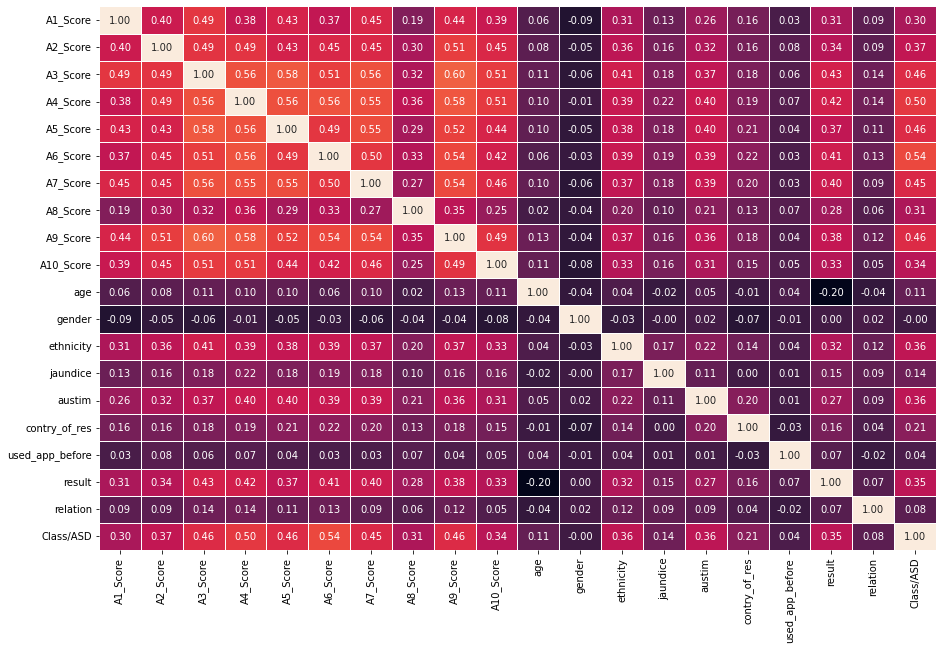

In [12]:
corr = df.corr()
plt.figure(figsize=(15, 10))
sns.heatmap(corr, annot=True, cbar=False, linewidths=.5, fmt= '.2f')
plt.show()

In [12]:
fig = go.Figure(go.Bar(x=df.columns,
                y=np.round(corr.values[-1,:], 2)))
fig.update_layout(width=800,
                height=400,
                title='Correlation between Features and Target')
fig.show()

In [18]:
X = df.drop('Class/ASD', axis=1)
y = df['Class/ASD']

# when y is set to stratify, the scores of all models are higher
# random_state param ensures the reproducibility of the initial shuffling
# of the train dataset after each epoch
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.1,
                                                    random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [20]:
# counts the number of occurrences of each value in an arr
print('Labels counts in y:', np.bincount(y))
print('Labels counts in y_train:', np.bincount(y_train))
print('Labels counts in y_test:', np.bincount(y_test))

Labels counts in y: [639 161]
Labels counts in y_train: [580 140]
Labels counts in y_test: [59 21]


In [21]:
models = {'Logistic regression': LogisticRegression(),
            'KNN': KNeighborsClassifier(),
            'SVC': SVC(probability=True),
            'Decision Tree': DecisionTreeClassifier(),
            'Random Forest': RandomForestClassifier(),
            'Gradient Boosting': GradientBoostingClassifier(),
            'Adaboost': AdaBoostClassifier(),
            'xgb': XGBClassifier()}

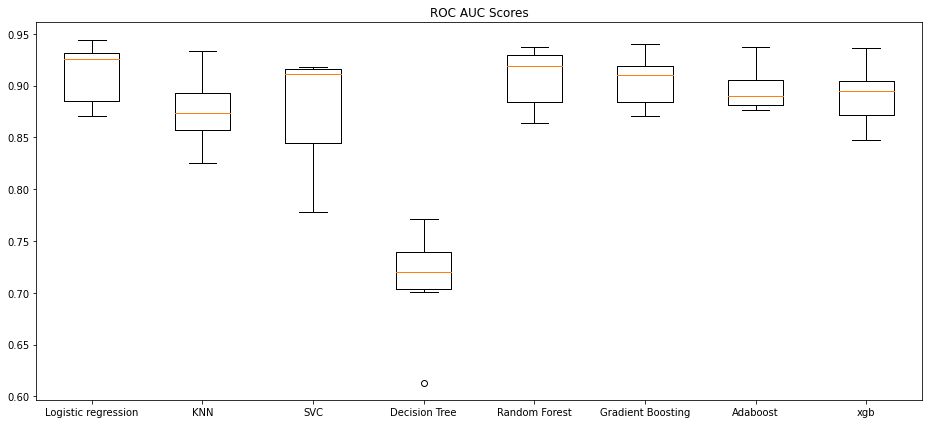

In [22]:
scores = []
for model in models.values():
    kf = KFold(n_splits=6, random_state=42, shuffle=True)
    cv_results = cross_val_score(model, X_train, y_train, scoring='roc_auc', cv=kf)
    scores.append(cv_results)

plt.figure(figsize=(13, 6))
plt.boxplot(scores, labels=models.keys())
plt.title('ROC AUC Scores')
plt.tight_layout()
plt.show()


In [23]:
for name, model in models.items():
    model.fit(X_train, y_train)
    test_score = roc_auc_score(y_test, model.predict_proba(X_test)[:,1])
    print('Test ROC AUC score: {}: {:.3f}'.format(name, test_score))

Test ROC AUC score: Logistic regression: 0.864
Test ROC AUC score: KNN: 0.851
Test ROC AUC score: SVC: 0.776
Test ROC AUC score: Decision Tree: 0.711
Test ROC AUC score: Random Forest: 0.875
Test ROC AUC score: Gradient Boosting: 0.860
Test ROC AUC score: Adaboost: 0.867
Test ROC AUC score: xgb: 0.839


In [24]:
from sklearn.metrics import roc_auc_score, roc_curve

def plot_roc_curve(prob_prediction, actual):
    fpr, tpr, thresholds = roc_curve(y_test, prob_prediction)
    auc_score = roc_auc_score(y_test, prob_prediction)
    
    plt.plot(fpr, tpr, label='ROC curve ')
    plt.plot([0, 1], [0, 1])
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC AUC: {:.3f}'.format(auc_score))
    plt.show()

### Logistic Regression

In [25]:
params = {'penalty': ['l1', 'l2'],
        'C': np.linspace(0.001, 1.0, 10)}
tuning_logreg = GridSearchCV(estimator=LogisticRegression(),
                        param_grid=params,
                        cv=5,
                        scoring='roc_auc')
tuning_logreg.fit(X_train, y_train)
print('Best hyperparams for Logistic Regression: {}'.format(
                                tuning_logreg.best_params_))
print('ROC AUC: {}'.format(np.round(tuning_logreg.score(X_test, y_test), 3)))

Best hyperparams for Logistic Regression: {'C': 0.001, 'penalty': 'l2'}
ROC AUC: 0.877


ROC AUC: 87.65


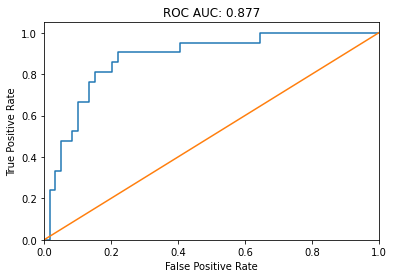

In [26]:
best_logreg = tuning_logreg.best_estimator_
y_pred_lr = best_logreg.predict_proba(X_test)[:,1]
print('ROC AUC: {:.2f}'.format(100*(roc_auc_score(y_test, y_pred_lr))))
plot_roc_curve(y_pred_lr, y_test)

In [32]:
y_pred_lr_ac = best_logreg.predict(X_test)

print('Misclassified examples: %d' % (y_test != y_pred_lr).sum())
print('Test accuracy score: %.3f' % accuracy_score(y_test, y_pred_lr_ac))

Misclassified examples: 80
Test accuracy score: 0.738


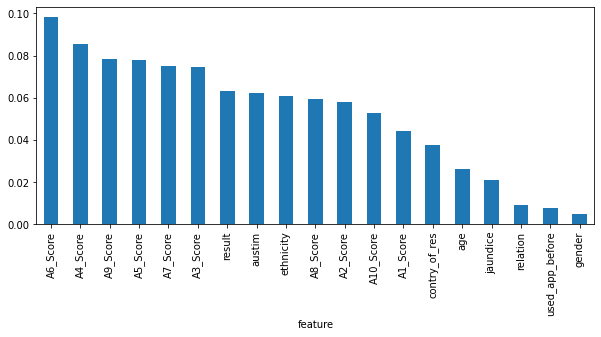

In [37]:
featureImportance = pd.DataFrame({'feature': df.drop('Class/ASD', axis=1).columns,
                                  "importance": best_logreg.coef_[0]})

featureImportance.set_index('feature', inplace=True)
featureImportance.sort_values(['importance'], ascending=False, inplace=True)
featureImportance["importance"].plot(kind = 'bar', figsize=(10, 4))
plt.show()

### Random Forest

In [21]:
# tree-based methods enable measuring the importance of each feature
# in prediction, i.e. how much the tree nodes use a particular feature
# (weighted average) to reduce impurity
# feature_importance_ attribute

# RandomForestClassifier().get_params()

params = {'n_estimators': [100, 200, 300],
        'max_depth': [3, 4, 5, 6],
        'min_samples_leaf': np.linspace(0.02, 0.08, 10),
        'max_features': ['sqrt', 'log2']}

tuning_rf = GridSearchCV(estimator=RandomForestClassifier(),
                        param_grid=params,
                        cv=3,
                        scoring='roc_auc',
                        n_jobs=-1)
tuning_rf.fit(X_train, y_train)
print('Best hyperparams for Random Forest:')
print('{}'.format(tuning_rf.best_params_))
print('ROC AUC: {}'.format(np.round(tuning_rf.score(X_test, y_test), 2)))

Best hyperparams for Random Forest:
{'max_depth': 6, 'max_features': 'sqrt', 'min_samples_leaf': 0.05333333333333333, 'n_estimators': 100}
ROC AUC: 0.88


ROC AUC: 87.93


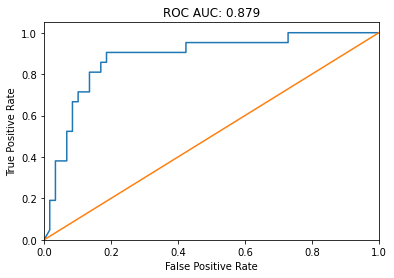

In [22]:
best_rf = tuning_rf.best_estimator_
y_pred_rf = best_rf.predict_proba(X_test)[:,1]
print('ROC AUC: {:.2f}'.format(100*(roc_auc_score(y_test, y_pred_rf))))
plot_roc_curve(y_pred_rf, y_test)

In [23]:
def feature_importance(best_model, model_name: str):
    '''Define importance of features and plot them.'''
    feature_imp = pd.Series(best_model.feature_importances_,
                                index=X.columns)
    sorted_features = feature_imp.sort_values()
    # plot feature importance
    fig = go.Figure(go.Bar(x=sorted_features,
                        y=sorted_features.index,
                        orientation='h'))
    fig.update_layout(width=800,
                    height=400,
                    title='{}: Feature Importance'.format(model_name))
    fig.show()

In [24]:
feature_importance(best_rf, 'Random Forest')

### Gradient Boosting Classifier

In [25]:
params = {'n_estimators': [50, 100, 200, 300],
        'max_depth': [1, 3, 4, 5, 6],
        'learning_rate': np.linspace(0.05, 0.6, num=10)}

tuning_grb = GridSearchCV(estimator=GradientBoostingClassifier(),
                        param_grid=params,
                        cv=3,
                        scoring='roc_auc',
                        n_jobs=-1)
tuning_grb.fit(X_train, y_train)
print('Best hyperparams for Gradient Boosting Classifier:')
print('{}'.format(tuning_grb.best_params_))
print('ROC AUC: {}'.format(np.round(tuning_grb.score(X_test, y_test), 2)))

Best hyperparams for Gradient Boosting Classifier:
{'learning_rate': 0.1111111111111111, 'max_depth': 1, 'n_estimators': 50}
ROC AUC: 0.88


ROC AUC: 87.93


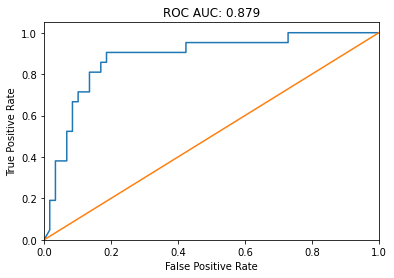

In [26]:
best_grb = tuning_rf.best_estimator_
y_pred_grb = best_grb.predict_proba(X_test)[:,1]
print('ROC AUC: {:.2f}'.format(100*(roc_auc_score(y_test, y_pred_grb))))
plot_roc_curve(y_pred_grb, y_test)

In [27]:
feature_importance(best_grb, 'Gradient Boosting')

### Dimensionality Reduction: PCA with Logistic Regression

In [28]:
pca = PCA(n_components=19)
pca.fit(X_train)
print('Cumulative variances (percentage):')
print(pca.explained_variance_ratio_.cumsum() * 100)

Cumulative variances (percentage):
[ 32.55588812  38.87652421  44.62871124  50.0797497   55.271408
  60.20683306  64.70168065  69.02627072  73.14814753  76.75681869
  80.08671981  83.25272227  86.05226752  88.78019977  91.42407215
  93.72708702  95.99800214  98.07411507 100.        ]


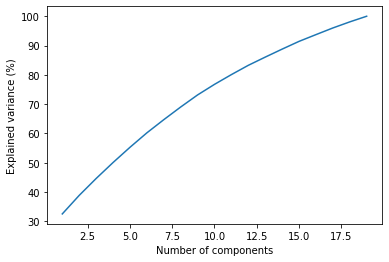

In [29]:
components = len(pca.explained_variance_ratio_)
plt.plot(range(1, components+1), 
        np.cumsum(pca.explained_variance_ratio_ * 100))
plt.xlabel("Number of components")
plt.ylabel("Explained variance (%)")
plt.show()

In [30]:
pca = PCA(n_components=0.80)
pca.fit(X_train)

components = len(pca.explained_variance_ratio_)
print(f'Number of components: {components}')

Number of components: 11


In [31]:
print('Top 4 most important features in each component:')

pca_components = abs(pca.components_)

for row in range(pca_components.shape[0]):
    # get the indices of the top 4 values in each row
    temp = np.argpartition(-(pca_components[row]), 4)
    
    # sort the indices in descending order
    indices = temp[np.argsort((-pca_components[row])[temp])][:4]
    
    # print the top 4 feature names
    print(f'Component {row}: {df.columns[indices].to_list()}')

Top 4 most important features in each component:
Component 0: ['A4_Score', 'A3_Score', 'A9_Score', 'A7_Score']
Component 1: ['age', 'result', 'relation', 'jaundice']
Component 2: ['contry_of_res', 'gender', 'jaundice', 'relation']
Component 3: ['used_app_before', 'gender', 'age', 'austim']
Component 4: ['gender', 'jaundice', 'relation', 'austim']
Component 5: ['relation', 'jaundice', 'used_app_before', 'contry_of_res']
Component 6: ['contry_of_res', 'jaundice', 'A8_Score', 'A1_Score']
Component 7: ['A8_Score', 'jaundice', 'used_app_before', 'contry_of_res']
Component 8: ['ethnicity', 'austim', 'gender', 'jaundice']
Component 9: ['A1_Score', 'ethnicity', 'austim', 'contry_of_res']
Component 10: ['A2_Score', 'A10_Score', 'A5_Score', 'austim']


In [32]:
m_pca = PCA(n_components=6)
model_pca = LogisticRegression()
logreg_pca_m = Pipeline([('pca', m_pca),
                        ('logreg', model_pca)])

logreg_pca_m.fit(X_train,y_train)

Pipeline(steps=[('pca', PCA(n_components=6)), ('logreg', LogisticRegression())])

ROC AUC: 87.09


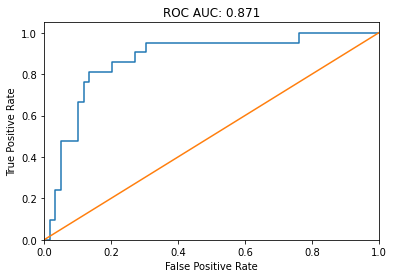

In [33]:
y_pred_pca = logreg_pca_m.predict_proba(X_test)[:,1]
print('ROC AUC: {:.2f}'.format(100*(roc_auc_score(y_test, y_pred_pca))))
plot_roc_curve(logreg_pca_m.predict_proba(X_test)[:,1], y_test)